In [1]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import ipywidgets as widgets

from torchvision.utils import save_image, make_grid

from scipy.spatial import cKDTree
from tqdm import tqdm


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
class MyModel(nn.Module):
    def __init__(self, embed_dim=64, hidden_dim=64, output_dim=2, t_range=500):
        super(MyModel, self).__init__()
        
        self.x_embedding = nn.Linear(2, embed_dim)
        
        self.t_embedding = nn.Sequential(
            nn.Embedding(t_range, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(embed_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, xT, t):
        t_tensor = torch.full((xT.size(0),1), t)

        embeded_xT = self.x_embedding(xT)
        embeded_t = self.t_embedding(t_tensor).squeeze(1)
        cat_embeded = torch.cat((embeded_xT, embeded_t), dim=1)

        out = self.fc(cat_embeded)
        return out



In [4]:
# diffuse 관련 변수 및 함수 정의

def make_beta_alpha(min_beta, max_beta, t_range, device=device):
    betas = torch.linspace(min_beta, max_beta, t_range).to(device)
    alphas = 1 - betas
    alpha_bars = torch.tensor([torch.prod(alphas[:(i+1)]) for i in range(t_range)]).to(device)
    return betas, alphas, alpha_bars

def diffuse_x(x0, t, alpha_bars, eta=None, device=device):
    if not isinstance(x0, torch.Tensor):
        x0 = torch.tensor(x0).to(device)
    else:
        x0 = x0.to(device)
        
    n, d = x0.shape
    a_bar = alpha_bars[t]

    if eta is None:
        eta = torch.randn(n, d).to(device)
    
    xT = a_bar.sqrt().view(-1,1) * x0 + (1 - a_bar).sqrt().view(-1,1) * eta

    return xT

In [5]:
# make vector field
def vector_field(vectors, scale=0.5):
    vf = vectors * scale
    return vf

In [6]:
# grid 생성
def make_grid(lim, n, device=device):
    x = np.linspace(-lim, lim, n)
    y = np.linspace(-lim, lim, n)
    X, Y = np.meshgrid(x, y)   # 20x20, 20x20
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1

    grid_points = np.concatenate([X, Y], axis=1)
    return torch.tensor(grid_points, device=device, dtype=torch.float32)

grid_points = make_grid(5, 20)

In [7]:
def draw_data(data, lim=5, title_str='Data', color='blue'):
    if isinstance(data, torch.Tensor):
        data = data.cpu()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(data[:,0], data[:,1], label='data', c=color, alpha=1, s=5)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title_str)
    ax.grid(True)

    plt.close(fig)

    return fig

In [8]:
def draw_vector_field(grid_points, vf, scale=5, color='blue', width=0.003, title='Vector Field'):
    if isinstance(grid_points, torch.Tensor):
        grid_points = grid_points.cpu().detach().numpy()
    if isinstance(vf, torch.Tensor):
        vf = vf.cpu().detach().numpy()
        
    X = grid_points[:, 0]
    Y = grid_points[:, 1]
    
    U = vf[:, 0]
    V = vf[:, 1]

    plt.figure(figsize=(8, 6))
    plt.quiver(X, Y, U, V, scale=scale, color=color, width=width)
    plt.xlabel('X')
    plt.xlabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [9]:
def make_training_data(grid_points, data, alpha_bars, eta=None, t_range=200, max_distance=0.5, device=device):
    if not isinstance(data, torch.Tensor):
        x0 = torch.tensor(data).to(device)
    else:
        x0 = data.to(device)

    if eta is None:
        eta = torch.randn_like(x0).to(device)

    vector_fields = []
    xTs = []

    for t in range(t_range):
        xT = diffuse_x(x0, t, alpha_bars, eta=eta)
        xTs.append(xT.clone().detach().cpu().numpy())
        
        tree = cKDTree(x0.detach().cpu().numpy())

        if isinstance(grid_points, torch.Tensor):
            grid_points = grid_points.detach().cpu().numpy()

        avg_vecs = np.zeros_like(grid_points)

        for i, point in enumerate(grid_points):
            indices = tree.query_ball_point(point, r=max_distance)
            if len(indices) == 0:
                avg_vecs[i] = np.array([0.0, 0.0])
                continue
            neighbor_vecs = xT[indices].cpu().numpy() - x0[indices].cpu().numpy()

            avg_vec = neighbor_vecs.mean(axis=0)
            avg_vecs[i] = avg_vec.copy()

        vector_fields.append(avg_vecs.copy())
        
    
    return xTs, vector_fields

In [10]:
def make_sample_data_2d(mean, cov, datanum=200):
    data = np.random.multivariate_normal(mean, cov, datanum)
    data = np.array(data, dtype=np.float32)
    return data.copy()

datanum = 500
# mean = np.array([0,0])
# cov = np.array([[.01,.001], [.001,.01]])
# data = torch.tensor(make_sample_data_2d(mean, cov, datanum))

# lim = 5
# fig = draw_data(data, lim)
# display(fig)

In [11]:
t_range = 100
min_beta = 1e-4
max_beta = 1e-2
scale = 1000 / t_range
betas, alphas, alpha_bars = make_beta_alpha(min_beta * scale, max_beta * scale, t_range)

### diffuse 시각화

In [12]:
data = torch.randn((datanum,2))
xTs_diffused = [data.clone().detach().cpu().numpy()]

eta = torch.randn_like(data)
for t in range(t_range):
    xT = diffuse_x(data, t, alpha_bars, eta=eta)
    xTs_diffused.append(xT.clone().detach().cpu().numpy())

In [13]:
t_slider = widgets.IntSlider(value=0, min=0, max=t_range-1, step=1, description='t')
def update(t):
    with torch.no_grad():
        fig = draw_data(xTs_diffused[t], 5, title_str="X_T at T = {}".format(t))
        display(fig)
        plt.close(fig)
        
widgets.interact(update, t=t_slider)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.update(t)>

### model 학습

In [14]:
model = MyModel(embed_dim=64, hidden_dim=128, output_dim=2, t_range=t_range)

In [15]:
epochs = 100
learning_rate = 0.1
losses = []

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
for eopch in tqdm(range(epochs), desc='Training Epochs'):
    for t in range(t_range):
        optimizer.zero_grad()

        data = torch.randn((datanum,2))

        # t = torch.randint(0, t_range, (1,)).item()

        eta = torch.randn_like(data)
        xT = diffuse_x(data, t, alpha_bars, eta=eta)

        ouput = model(xT, t)

        eta_for_obj = (1/(1-alpha_bars[t])) * (xT - alpha_bars[t] * data)
        loss = criterion(ouput.to(device), eta.to(device))

        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        # loss = criterion(eta_for_obj.to(device), ouput.to(device))

Training Epochs: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


In [16]:
print("Final loss: {}".format( losses[-1]))

Final loss: 0.0073899030685424805


### 학습된 model로 reverse process

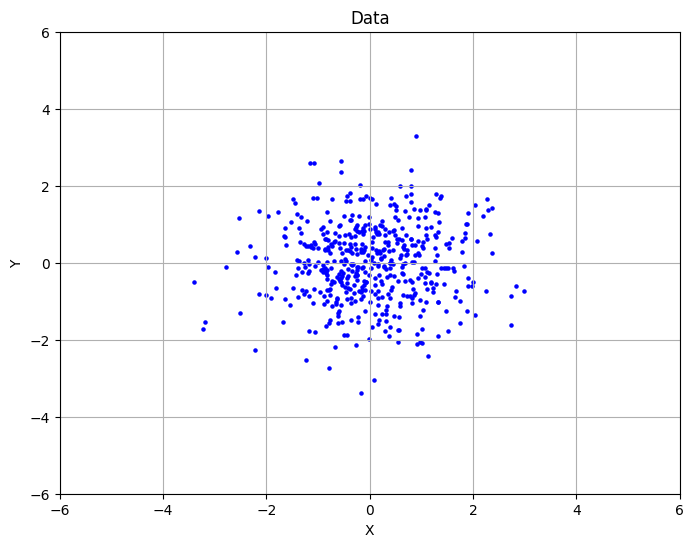

In [17]:
# mean = np.array([0, 0])
# cov = np.array([[.1, 0.01], [0.01, .1]])
# data = torch.tensor(make_sample_data_2d(mean, cov, 300))
data = torch.empty((datanum, 2)).normal_()

display(draw_data(data, 6))

xTs = [data.clone().detach().cpu().numpy()]

model.eval()

for t in range(t_range-1, -1, -1):
    xT_1 = (1 / alphas[t].sqrt())*(data - (betas[t] / (1-alpha_bars[t]).sqrt()) * model(data, t))

    xTs.append(xT_1.clone().detach().cpu().numpy())

In [18]:
t_slider = widgets.IntSlider(value=t_range-1, min=0, max=t_range-1, step=1, description='t')
def update(t):
    with torch.no_grad():
        fig = draw_data(xTs[t], 3, title_str="X_T at T = {}".format(t))
        display(fig)
        
widgets.interact(update, t=t_slider)

interactive(children=(IntSlider(value=99, description='t', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.update(t)>

In [19]:
# # mean = np.array([0, 0])
# # cov = np.array([[3, 0.3], [0.3, 3]])
# data = torch.randn((datanum,2))

# # draw_data(data, 6)

# xTs = [data.clone().detach().cpu().numpy()]

# model.eval()

# for t in range(t_range):
#     eta = model(data, t)
#     xT = diffuse_x(data, t, alpha_bars, eta=eta)

#     xTs.append(xT.clone().detach().cpu().numpy())

In [20]:
# t_slider = widgets.IntSlider(value=0, min=0, max=t_range-1, step=1, description='t')
# def update(t):
#     with torch.no_grad():
#         fig = draw_data(xTs[t], 3, title_str="X_T at T = {}".format(t))
#         display(fig)
        
# widgets.interact(update, t=t_slider)

In [21]:
# xTs, training_data = make_training_data(grid_points, data, alpha_bars, eta=eta, t_range=t_range)
# for i, td in enumerate(training_data):
#     training_data[i] = vector_field(td, scale=.3)

# # training data 저장
# np.savez('xTs_and_vfs.npz', xTs=xTs, training_data=training_data)

# # training data 로드
# loaded = np.load('xTs_and_vfs.npz')
# xTs = loaded['xTs']
# training_data = loaded['training_data']

In [22]:
# draw_data(data)
# draw_data(xTs[499])
# draw_vector_field(grid_points, training_data[499])